In [1]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

In [2]:
import cvxpy as cp
import numpy as np

In [3]:
from solara.constants import PROJECT_PATH
import solara.envs.components.solar
import solara.envs.components.load
import solara.envs.components.grid
pv_data_path = PROJECT_PATH + "/data/solar_trace_data/PV_5796.txt"
load_data_path = PROJECT_PATH + "/data/solar_trace_data/load_5796.txt"

pv_model = solara.envs.components.solar.DataPV(data_path=pv_data_path)
load_model = solara.envs.components.load.DataLoad(data_path=load_data_path)
grid_model = solara.envs.components.grid.PeakGrid()

pv_model.fix_start(1)
load_model.fix_start(1)

In [4]:
start = np.random.randint(len(pv_model.data) // 24) * 24

pv_model.reset()
load_model.reset()
print("Starting point: ", pv_model.start)
for i in range(24):
    load = load_model.get_next_load()
    pv_gen = pv_model.get_next_generation()
    net_load = np.maximum(0,load-pv_gen)
    price = grid_model.draw_power(net_load)
    print("Load: {:.3f}, PV generation: {:.3f}, Net load: {:.3f}, Price: {:.3f}".format(load, pv_gen, net_load, price))

Starting point:  24
Load: 0.388, PV generation: 0.000, Net load: 0.388, Price: 0.054
Load: 0.401, PV generation: 0.000, Net load: 0.401, Price: 0.056
Load: 0.396, PV generation: 0.000, Net load: 0.396, Price: 0.055
Load: 0.371, PV generation: 0.000, Net load: 0.371, Price: 0.052
Load: 0.354, PV generation: 0.000, Net load: 0.354, Price: 0.050
Load: 0.382, PV generation: 0.000, Net load: 0.382, Price: 0.053
Load: 0.382, PV generation: 0.000, Net load: 0.382, Price: 0.054
Load: 0.736, PV generation: 0.005, Net load: 0.731, Price: 0.102
Load: 0.759, PV generation: 0.088, Net load: 0.671, Price: 0.094
Load: 0.938, PV generation: 0.342, Net load: 0.596, Price: 0.083
Load: 1.130, PV generation: 0.774, Net load: 0.355, Price: 0.050
Load: 0.959, PV generation: 0.864, Net load: 0.095, Price: 0.013
Load: 3.110, PV generation: 0.890, Net load: 2.221, Price: 0.845
Load: 1.084, PV generation: 0.813, Net load: 0.271, Price: 0.038
Load: 2.113, PV generation: 0.651, Net load: 1.462, Price: 0.205
Load:

In [9]:
import solara.envs.battery_control
import solara.envs.components.battery

battery_model = solara.envs.components.battery.LithiumIonBattery(20, "NMC", 1/10.0)
pv_model = solara.envs.components.solar.DataPV(data_path=pv_data_path)
load_model = solara.envs.components.load.DataLoad(data_path=load_data_path)
grid_model = solara.envs.components.grid.PeakGrid()

start = 12

pv_model.fix_start(start=start)
load_model.fix_start(start=start)

env = solara.envs.battery_control.BatteryControlEnv(battery=battery_model,
        pv_system = pv_model,
        grid = grid_model,
        load = load_model,
        logging_level="DEBUG")

INFO:LithiumIonBattery:Environment component initialised.
INFO:DataPV:Environment component initialised.
INFO:DataLoad:Environment component initialised.
INFO:PeakGrid:Environment component initialised.
INFO:BatteryControlEnv:Environment initialised.
DEBUG:BatteryControlEnv:Environment reset.


In [11]:
done = False
env.reset()
obs_list = []
for i in range(26):
    if not done:
        obs, _, done, _ = env.step(np.array([-1]))
        obs_list.append(obs)
    else:
        print("Episode done.")

DEBUG:BatteryControlEnv:Environment reset.
DEBUG:BatteryControlEnv:step action: -1.000
DEBUG:LithiumIonBattery:Charged 0.0000kW (attempted -20.0000), new content 0.00kWh
DEBUG:BatteryControlEnv:step return: obs: [0.339 0.    0.    1.    0.339 0.   ], rew: -0.000, done: False
DEBUG:BatteryControlEnv:step action: -1.000
DEBUG:LithiumIonBattery:Charged 0.0000kW (attempted -20.0000), new content 0.00kWh
DEBUG:BatteryControlEnv:step return: obs: [0.356 0.    0.    2.    0.695 0.   ], rew: -0.047, done: False
DEBUG:BatteryControlEnv:step action: -1.000
DEBUG:LithiumIonBattery:Charged 0.0000kW (attempted -20.0000), new content 0.00kWh
DEBUG:BatteryControlEnv:step return: obs: [0.336 0.    0.    3.    1.031 0.   ], rew: -0.050, done: False
DEBUG:BatteryControlEnv:step action: -1.000
DEBUG:LithiumIonBattery:Charged 0.0000kW (attempted -20.0000), new content 0.00kWh
DEBUG:BatteryControlEnv:step return: obs: [0.343 0.    0.    4.    1.374 0.   ], rew: -0.047, done: False
DEBUG:BatteryControlEnv:s

Episode done.
Episode done.


<AxesSubplot:>

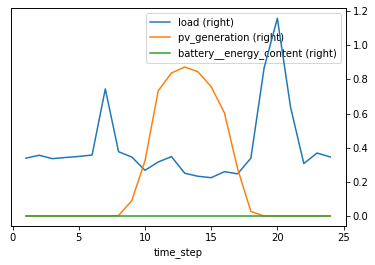

In [8]:
import pandas as pd

df = pd.DataFrame(data=obs_list)
df.columns = ["load",
            "pv_generation",
            "battery__energy_content",
            "time_step",
            "sum_load",
            "sum_pv_gen",]

y_names = ["load",
            "pv_generation",
            "battery__energy_content",]
            #"sum_load",
            #"sum_pv_gen",]
        
df.plot(x="time_step", y=y_names, secondary_y=True)